In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import kipoiseq
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from EPInformer.models import EPInformer_v2
from scripts.utils import encoder_promoter_enhancer_CRISPRi, FastaStringExtractor, one_hot_encode, compute_enhancer_gene_attention, perturb_enhancer

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Pre-process CRISPRi-FlowFISH data
#### 1. Retain the enhancer-gene within 100kb to the target gene
#### 2. Keep the Xpresso selected genes (i.e., protein-coding gene)
#### 3. Filter out the genes with no CRISPRi-validated enhancer

In [4]:
# Orignal CRISPRi-FlowFISH data from Fulco et al. 2019
flowfish_df = pd.read_excel('./data/CRISPRi-FlowFISH_Fulco2019/41588_2019_538_MOESM3_ESM.xlsx',sheet_name='Supplementary Table 6a', skiprows=[0])
RNA_feats = pd.read_csv('./data/GM12878_K562_18377_gene_expr_fromXpresso.csv', index_col='Gene stable ID')[['Gene name', 'UTR5LEN_log10zscore','CDSLEN_log10zscore','INTRONLEN_log10zscore','UTR3LEN_log10zscore','UTR5GC','CDSGC','UTR3GC', 'ORFEXONDENSITY_log10zscore']]
ensid_gene = RNA_feats[['Gene name']].reset_index()
flowfish_df['significant_enhancer'] = flowfish_df['Significant']&(flowfish_df['Fraction change in gene expr'] < 0)
flowfish_df = flowfish_df.merge(ensid_gene, left_on='Gene', right_on='Gene name', how='left')
flowfish_df['Xpresso_gene'] = False
intersec_ensid = list(set(flowfish_df['Gene stable ID']).intersection(set(RNA_feats.index)))
flowfish_df = flowfish_df.set_index('Gene stable ID')
flowfish_df.loc[intersec_ensid, 'Xpresso_gene'] = True
# Keep the Xpresso selected genes (protein-coding gene)
flowfish_df = flowfish_df[flowfish_df['Xpresso_gene']].reset_index()
flowfish_df['mid'] = flowfish_df['start'] + (flowfish_df['end'] - flowfish_df['start'])/2
flowfish_df['Distance_withDirect'] = flowfish_df['mid'] - flowfish_df['Gene TSS']
flowfish_df['Distance'] = np.abs(flowfish_df['Distance_withDirect'])
# Retain the enhancer-gene within 100kb to the TSS
flowfish_100kb_df = flowfish_df[flowfish_df['Distance'] <= 100_000]
expr_df = pd.read_csv('./data/GM12878_K562_18377_gene_expr_fromXpresso.csv', index_col='ENSID')[['K562_CAGE_128*3_sum', 'Actual_K562']]
expr_flowfish_100kb_df = expr_df.merge(flowfish_100kb_df, left_index=True, right_on='Gene stable ID', how='right').reset_index()
# All gene
gene_list = flowfish_100kb_df['Gene name'].dropna().unique()

## Enhancer-gene prioritization by EPInformer-drived attention scores and Attention-ABC score

In [5]:
split_df = pd.read_csv('./data/leave_chrom_out_crossvalidation_split_18377genes.csv', index_col=0)
fold_chr_dict = {}
cols = ['chrom'] + ['fold_'+str(i) for i in range(1, 13)]
for idx, row in split_df.drop_duplicates(subset=['chrom'])[cols].iterrows():
    for col in cols[1:]:
        if row[col] == 'test':
            fold_chr_dict['chr' + row['chrom']] = col
            break
print(fold_chr_dict)

device = 'cpu'
expr_type = 'CAGE'
use_pretrained = True
pred_df_dict = {}
for gene_name in tqdm(gene_list):
    pe_df = expr_flowfish_100kb_df[expr_flowfish_100kb_df['Gene'] == gene_name]
    pe_df = pe_df.sort_values(by='Distance')
    g_chr = pe_df.iloc[0]['chr']
    model_fold = fold_chr_dict[g_chr] # /Users/jieconlin3/Documents/EPInformer/trained_models/EPInformer_PE_Activity/K562/fold_2_EPInformer_PE_Activity_CAGE_K562_checkpoint.pt
    # Load EPInformer-PE-Activity
    model_name = 'EPInformer_PE_Activity_{}_K562'.format(expr_type)
    EPInformer_PE_activity = EPInformer_v2(n_encoder=3, n_enhancer=len(pe_df), out_dim=64, n_extraFeat=2, device=device, useLN=True).to(device)
    model_path = "./trained_models/EPInformer_PE_Activity/K562/{}_{}_checkpoint.pt".format(model_fold, model_name)
    checkpoint = torch.load(model_path, map_location=torch.device(device))
    EPInformer_PE_activity.load_state_dict(checkpoint['model_state_dict'])
    EPInformer_PE_activity.eval()
    # Load EPInformer-PE-Activity-HiC
    model_name = 'EPInformer_PE_Activity_HiC_{}_K562'.format(expr_type)
    EPInformer_PE_activity_HiC = EPInformer_v2(n_encoder=3, n_enhancer=len(pe_df), out_dim=64, n_extraFeat=3, device=device, useLN=True).to(device)
    model_path = "./trained_models/EPInformer_PE_Activity_HiC/K562/{}_{}_checkpoint.pt".format(model_fold, model_name)
    checkpoint = torch.load(model_path, map_location=torch.device(device))
    EPInformer_PE_activity_HiC.load_state_dict(checkpoint['model_state_dict'])
    EPInformer_PE_activity_HiC.eval()
    # Compute attention weights
    attention_mean_noHiC, all_expr_noHiC = compute_enhancer_gene_attention(EPInformer_PE_activity, pe_df, use_hic=False, device=device)
    attention_mean_HiC, all_expr_HiC = compute_enhancer_gene_attention(EPInformer_PE_activity_HiC, pe_df, use_hic=True, device=device)

    pe_df['attention_weight_noHiC'] = attention_mean_noHiC
    pe_df['pred_expr_noHiC'] = all_expr_noHiC
    pe_df['attention_weight_HiC'] = attention_mean_HiC
    pe_df['pred_expr_HiC'] = all_expr_HiC
    pe_df['actual_CAGE'] = np.log10(1+pe_df.iloc[0]['K562_CAGE_128*3_sum'])
    pe_df['actual_RNA'] = pe_df.iloc[0]['Actual_K562']
    pe_df['expr_type'] = expr_type
    pe_df['fold_i'] = model_fold
    pred_df_dict[gene_name] = pe_df
    

{'chrX': 'fold_11', 'chr20': 'fold_9', 'chr1': 'fold_12', 'chr6': 'fold_5', 'chr3': 'fold_2', 'chr7': 'fold_6', 'chr12': 'fold_1', 'chr11': 'fold_10', 'chr4': 'fold_3', 'chr17': 'fold_6', 'chr2': 'fold_1', 'chr16': 'fold_5', 'chr8': 'fold_7', 'chr19': 'fold_8', 'chr9': 'fold_8', 'chr13': 'fold_2', 'chr14': 'fold_3', 'chr5': 'fold_4', 'chr22': 'fold_11', 'chr10': 'fold_9', 'chr18': 'fold_7', 'chr15': 'fold_4', 'chr21': 'fold_10'}


100%|██████████| 55/55 [02:14<00:00,  2.45s/it]


In [6]:
score_df = []
for gk in pred_df_dict.keys():
    gene_flowfish_100kb = pred_df_dict[gk]
    gene_flowfish_100kb['-Distance'] = -gene_flowfish_100kb['Distance']
    gene_flowfish_100kb['Attention score HiC'] = gene_flowfish_100kb['attention_weight_HiC']/gene_flowfish_100kb['attention_weight_HiC'].sum()
    gene_flowfish_100kb['Attention score noHiC'] = gene_flowfish_100kb['attention_weight_noHiC']/gene_flowfish_100kb['attention_weight_noHiC'].sum()
    gene_flowfish_100kb['Activity score'] = gene_flowfish_100kb['Activity']/gene_flowfish_100kb['Activity'].sum()
    gene_flowfish_100kb['Attention-ABC score'] = gene_flowfish_100kb['Attention score noHiC']*gene_flowfish_100kb['Normalized HiC Contacts']*gene_flowfish_100kb['Activity']
    gene_flowfish_100kb['Attention-ABC score'] = gene_flowfish_100kb['Attention-ABC score']/gene_flowfish_100kb['Attention-ABC score'].sum()
    gene_flowfish_100kb['ABC score'] = gene_flowfish_100kb['Activity']*gene_flowfish_100kb['Normalized HiC Contacts']
    gene_flowfish_100kb['ABC score'] = gene_flowfish_100kb['ABC score']/gene_flowfish_100kb['ABC score'].sum()
    gene_flowfish_100kb['#enhancer'] = len(gene_flowfish_100kb)
    if sum(gene_flowfish_100kb['significant_enhancer']) == 0:
        print(gk, 'is filtered out, as it has no validated enhancer')
        gene_flowfish_100kb['with_validated_enhancer'] = False
    else:
        gene_flowfish_100kb['with_validated_enhancer'] = True
    if 'level_0' in gene_flowfish_100kb.columns:
        gene_flowfish_100kb = gene_flowfish_100kb.drop(columns=['level_0'])
    score_df.append(gene_flowfish_100kb)

score_df = pd.concat(score_df).reset_index()# 
score_wE_df = score_df[score_df['with_validated_enhancer']]

MYC is filtered out, as it has no validated enhancer
CNDP2 is filtered out, as it has no validated enhancer
BAX is filtered out, as it has no validated enhancer
CNBP is filtered out, as it has no validated enhancer
COPZ1 is filtered out, as it has no validated enhancer
ITGA5 is filtered out, as it has no validated enhancer
PPP1R15A is filtered out, as it has no validated enhancer
RAB7A is filtered out, as it has no validated enhancer
RPN1 is filtered out, as it has no validated enhancer
SEC61A1 is filtered out, as it has no validated enhancer


In [7]:
'Total gene: {}'.format(len(score_wE_df['Gene name'].unique())), 'Total enhancer-gene links: {}'.format(len(score_wE_df))

('Total gene: 45', 'Total enhancer-gene links: 774')

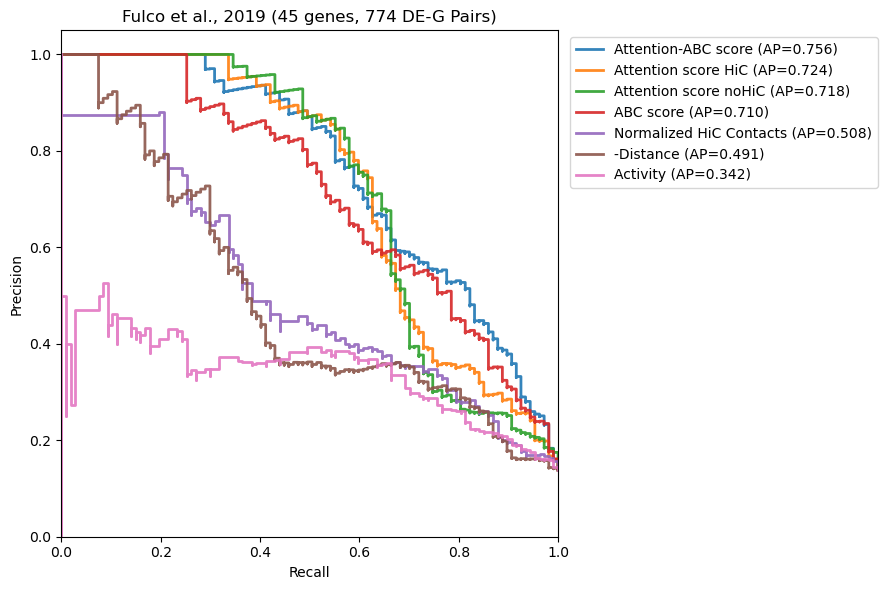

In [10]:
precision = dict()
recall = dict()
average_precision = dict()
label = 'significant_enhancer'
score_list = ['Attention-ABC score', 'Attention score HiC', 'Attention score noHiC', 'ABC score', 'Normalized HiC Contacts', '-Distance', 'Activity']
for col in score_list:
    attn_df = score_wE_df
    precision[col], recall[col], _ = precision_recall_curve(attn_df[label], attn_df[col])
    average_precision[col] = average_precision_score(attn_df[label], attn_df[col])
    # print(average_precision_score(attn_df[label], attn_df[col]), col)
    # print(col, average_precision[col])
_, ax = plt.subplots(figsize=(9, 6))
for i in score_list:
    i = i
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=i, linewidth=2, alpha=0.9)
handles, labels = display.ax_.get_legend_handles_labels()

# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
for i, l in enumerate(labels):
    mname = l.split(' (')[0]
    AP = average_precision[mname]
    labels[i] = mname + ' (AP={:.3f})'.format(AP)

# ax.legend(handles=handles, labels=labels, loc="best")
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.01, 1.0), loc='upper left')
ax.set_title("Fulco et al., 2019 (45 genes, 774 DE-G Pairs)")
plt.tight_layout()
plt.savefig('./images/fulco2019_auprc.pdf', transparent=True)

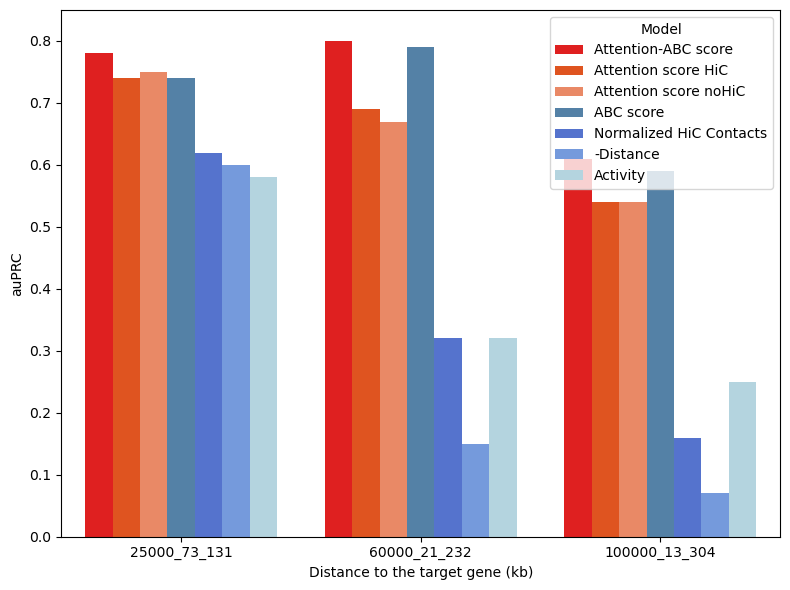

In [12]:
label = 'significant_enhancer'
res_list = []
score_list = ['Attention-ABC score', 'Attention score HiC', 'Attention score noHiC', 'ABC score', 'Normalized HiC Contacts', '-Distance', 'Activity']
distance_list = [0,  25_000, 60_000, 100_000]
all_df = []
for i, dist in enumerate(distance_list):
    if dist == 100_000:
        break
    # print('-'*10, distance_list[i+1], '-'*10)
    for m in score_list:
        sub_pe_df = score_wE_df[(score_wE_df['Distance'] <= distance_list[i+1])&(score_wE_df['Distance'] > distance_list[i])]
        # sub_pe_df = sub_pe_df[sub_pe_df['with_validated_enhancer']]
        # print(m, average_precision_score(sub_pe_df[label], sub_pe_df[m]))
        res_list.append([distance_list[i+1], sum(sub_pe_df[label]),sum(~sub_pe_df[label]), m, np.round(average_precision_score(sub_pe_df[label], sub_pe_df[m]),2)])
    all_df.append(sub_pe_df)
res_df = pd.DataFrame(res_list, columns=['DistanceToTSS', 'No.Pos', 'No.Neg', 'Model', 'auPRC'])
res_df['Distance_nPos'] = res_df['DistanceToTSS'].astype(str) + '_' + res_df['No.Pos'].astype(str) + '_' + res_df['No.Neg'].astype(str)
res_df = pd.DataFrame(res_list, columns=['DistanceToTSS', 'No.Pos', 'No.Neg', 'Model', 'auPRC'])
res_df['Distance_nPos'] = res_df['DistanceToTSS'].astype(str) + '_' + res_df['No.Pos'].astype(str) + '_' + res_df['No.Neg'].astype(str)
plt.figure(figsize=(8, 6))
# score_list = ['ABA-HiC score', 'ABA score', 'Attention score',  'ABC score', 'HiC', 'Activity', 'Distance']
colors = ['red',  'orangered', 'coral',  'steelblue', 'royalblue' ,'cornflowerblue', 'lightblue'] # 'tomato',
sns.barplot(x='Distance_nPos', y='auPRC', hue='Model', data=res_df, hue_order=score_list,  palette=colors, linewidth=0)
plt.ylim(0, 0.85)
plt.xlabel('Distance to the target gene (kb)')
# plt.xticks(range(4), ["1-5", "5-20","20-60","60-100"])
# plt.grid(axis='y',color='grey', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./images/fulco2019_auprc_distance.pdf', transparent=True)
# plt.savefig('/content/drive/MyDrive/EPInformer/EPInformer_CAGE_EG_auprc_distance_0507.pdf', transparent=True)

## In-silico perturbation on *KLF1* using EPInformer-PE-Activity and EPInformer-PE-Activity-HiC

In [8]:
# in-silco perturbation using EPInformer-PE-Activity-HiC
gene_name = 'KLF1'
pe_annot_df = expr_flowfish_100kb_df[expr_flowfish_100kb_df['Gene name'] == gene_name]
device = 'cpu'
EPInformer_PE_activity_HiC = EPInformer_v2(n_encoder=3, n_enhancer=len(pe_annot_df), out_dim=64, n_extraFeat=3, device=device, useFeat=True, usePromoterSignal=True, useLN=True)
model_path = './trained_models/EPInformer_PE_Activity_HiC/K562/fold_8_EPInformer_PE_Activity_HiC_CAGE_K562_checkpoint.pt'
checkpoint = torch.load(model_path, map_location=torch.device(device))
EPInformer_PE_activity_HiC.load_state_dict(checkpoint['model_state_dict'])
net = EPInformer_PE_activity_HiC.to(device)
perturb_HiC = perturb_enhancer(EPInformer_PE_activity_HiC, pe_annot_df, use_hic=True)
perturb_HiC.sort_values(by=['Distance_withDirect'], inplace=True)

ENSG00000105610 KLF1 chr19
Calucuting the change of predicted expression by in-silico perturbation...


100%|██████████| 37/37 [00:24<00:00,  1.53it/s]


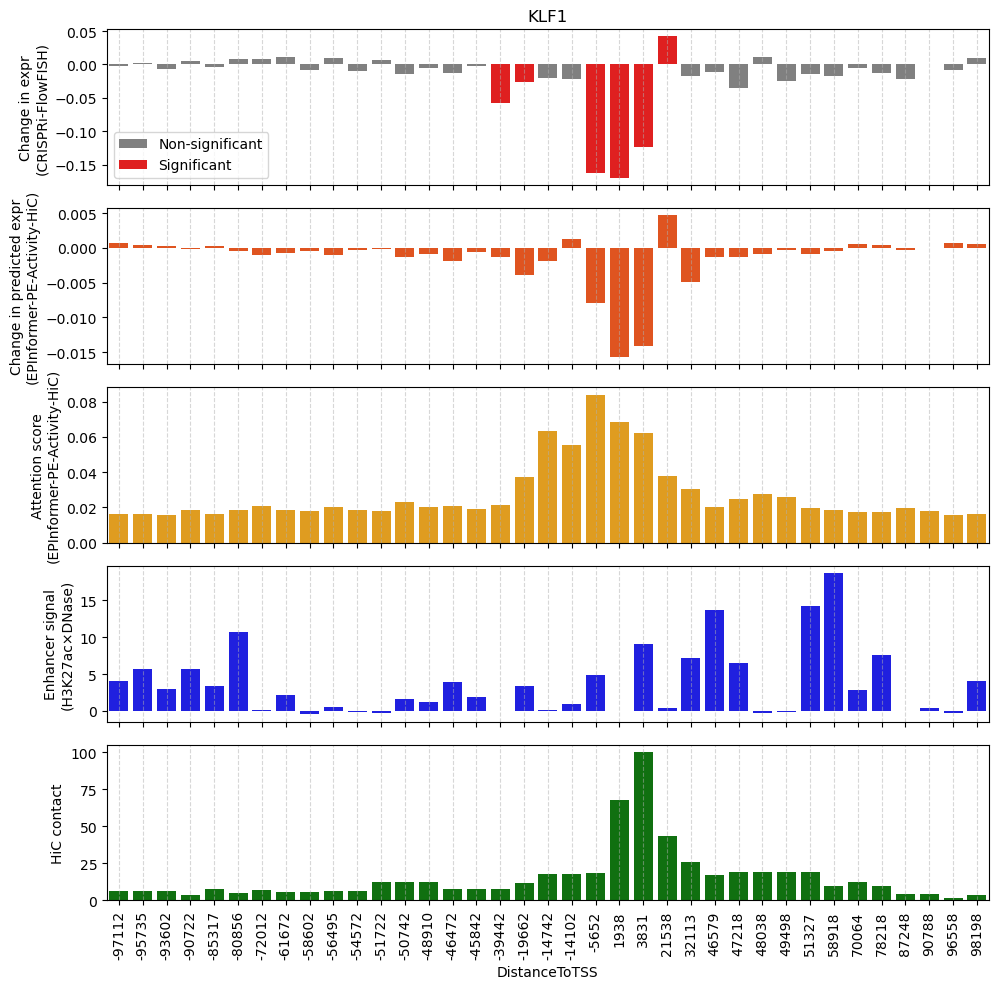

In [9]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(511)
plt.title('KLF1')
sns.barplot(x='Distance_withDirect', y='Fraction change in gene expr', data=perturb_HiC, ax=ax1, linewidth=0, color='grey', label='Non-significant')
perturb_HiC['EffectSize_significant'] = perturb_HiC['Fraction change in gene expr']*(perturb_HiC['Significant'] == True).astype(int)
sns.barplot(x='Distance_withDirect', y='EffectSize_significant', data=perturb_HiC, ax=ax1, color='red', linewidth=0, label='Significant')
plt.grid(axis='x', ls='--', alpha=0.5)
plt.tick_params('x', labelbottom=False)
plt.xlabel('')
plt.ylabel('Change in expr\n(CRISPRi-FlowFISH)')

ax2 = plt.subplot(512, sharex=ax1)
perturb_HiC['Distance_withDirect'] = perturb_HiC['Distance_withDirect'].astype(int)
sns.barplot(x='Distance_withDirect', y='change of predicted expression', data=perturb_HiC, ax=ax2, linewidth=0, color='orangered')
plt.xlabel('')
plt.ylabel('')
plt.tick_params('x', labelbottom=False)
plt.grid(axis='x', ls='--', alpha=0.5)
plt.ylabel('Change in predicted expr\n(EPInformer-PE-Activity-HiC)')

ax3 = plt.subplot(513, sharex=ax1)
perturb_HiC['Distance_withDirect'] = perturb_HiC['Distance_withDirect'].astype(int)
sns.barplot(x='Distance_withDirect', y='Attention score', data=perturb_HiC, ax=ax3, linewidth=0, color='orange')
plt.xlabel('')
plt.ylabel('')
plt.tick_params('x', labelbottom=False)
plt.grid(axis='x', ls='--', alpha=0.5)
plt.ylabel('Attention score\n(EPInformer-PE-Activity-HiC)')

ax4 = plt.subplot(514, sharex=ax1)
sns.barplot(x='Distance_withDirect', y='enhancer activity', data=perturb_HiC, ax=ax4, linewidth=0, color='blue')
plt.tick_params('x', labelbottom=False)
plt.ylabel('Enhancer signal\n(H3K27ac×DNase)')
plt.grid(axis='x', ls='--', alpha=0.5)
plt.xlabel('')

ax5 = plt.subplot(515, sharex=ax1)
sns.barplot(x='Distance_withDirect', y='HiC contact', data=perturb_HiC, ax=ax5, linewidth=0, color= 'green')
plt.ylabel('HiC contact')
plt.xlabel('DistanceToTSS')

plt.grid(axis='x', ls='--', alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('./images/KLF1_insilico_perturbation_EPInformer_PE_Activity_HiC.png', dpi=200)

In [17]:
# in-silco perturbation
gene_name = 'KLF1'
pe_annot_df = expr_flowfish_100kb_df[expr_flowfish_100kb_df['Gene name'] == gene_name]
device = 'cpu'
EPInformer_PE_activity = EPInformer_v2(n_encoder=3, n_enhancer=len(pe_annot_df), out_dim=64, n_extraFeat=2, device=device, useFeat=True, usePromoterSignal=True, useLN=True)
model_path = './trained_models/EPInformer_PE_Activity/K562/KLF1_test_EPInformer_PE_Activity_CAGE_K562_checkpoint.pt'
checkpoint = torch.load(model_path, map_location=torch.device(device))
EPInformer_PE_activity.load_state_dict(checkpoint['model_state_dict'])
EPInformer_PE_activity = EPInformer_PE_activity.to(device)
perturb_noHiC = perturb_enhancer(EPInformer_PE_activity, pe_annot_df, use_hic=False)
perturb_noHiC.sort_values(by=['Distance_withDirect'], inplace=True)

ENSG00000105610 KLF1 chr19
Calucuting the change of predicted expression by in-silico perturbation...


100%|██████████| 37/37 [00:18<00:00,  1.97it/s]


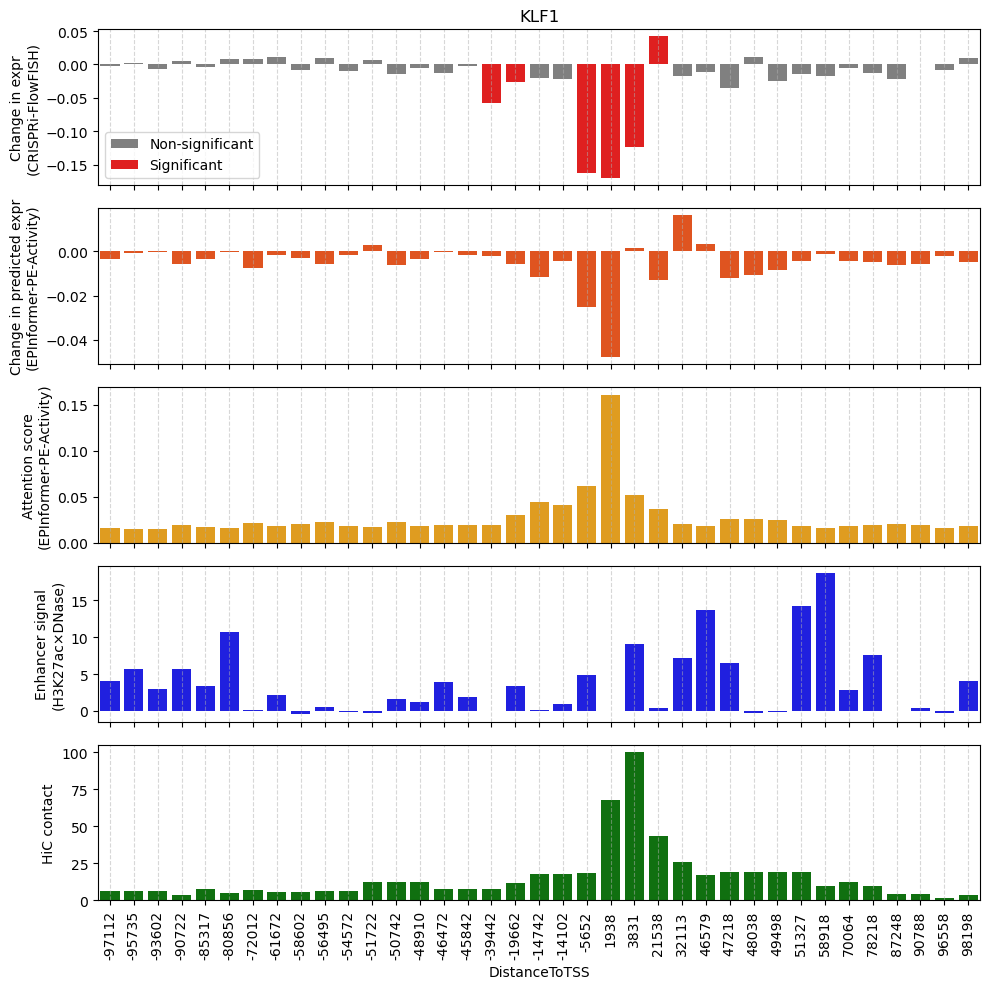

In [16]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(511)
plt.title('KLF1')
sns.barplot(x='Distance_withDirect', y='Fraction change in gene expr', data=perturb_noHiC, ax=ax1, linewidth=0, color='grey', label='Non-significant')
perturb_noHiC['EffectSize_significant'] = perturb_noHiC['Fraction change in gene expr']*(perturb_noHiC['Significant'] == True).astype(int)
sns.barplot(x='Distance_withDirect', y='EffectSize_significant', data=perturb_noHiC, ax=ax1, color='red', linewidth=0, label='Significant')
plt.grid(axis='x', ls='--', alpha=0.5)
plt.tick_params('x', labelbottom=False)
plt.xlabel('')
plt.ylabel('Change in expr\n(CRISPRi-FlowFISH)')

ax2 = plt.subplot(512, sharex=ax1)
perturb_noHiC['Distance_withDirect'] = perturb_noHiC['Distance_withDirect'].astype(int)
sns.barplot(x='Distance_withDirect', y='change of predicted expression', data=perturb_noHiC, ax=ax2, linewidth=0, color='orangered')
plt.xlabel('')
plt.ylabel('')
plt.tick_params('x', labelbottom=False)
plt.grid(axis='x', ls='--', alpha=0.5)
plt.ylabel('Change in predicted expr\n(EPInformer-PE-Activity)')

ax3 = plt.subplot(513, sharex=ax1)
perturb_noHiC['Distance_withDirect'] = perturb_noHiC['Distance_withDirect'].astype(int)
sns.barplot(x='Distance_withDirect', y='Attention score', data=perturb_noHiC, ax=ax3, linewidth=0, color='orange')
plt.xlabel('')
plt.ylabel('')
plt.tick_params('x', labelbottom=False)
plt.grid(axis='x', ls='--', alpha=0.5)
plt.ylabel('Attention score\n(EPInformer-PE-Activity)')

ax4 = plt.subplot(514, sharex=ax1)
sns.barplot(x='Distance_withDirect', y='enhancer activity', data=perturb_noHiC, ax=ax4, linewidth=0, color='blue')
plt.tick_params('x', labelbottom=False)
plt.ylabel('Enhancer signal\n(H3K27ac×DNase)')
plt.grid(axis='x', ls='--', alpha=0.5)
plt.xlabel('')

ax5 = plt.subplot(515, sharex=ax1)
sns.barplot(x='Distance_withDirect', y='HiC contact', data=perturb_noHiC, ax=ax5, linewidth=0, color= 'green')
plt.ylabel('HiC contact')
plt.xlabel('DistanceToTSS')

plt.grid(axis='x', ls='--', alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('./images/KLF1_insilico_perturbation_EPInformer_PE_Activity.png', dpi=200)